In [4]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import osmnx as ox
import networkx as nx
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

In [5]:
# Load dataset
data = pd.read_csv('../datasets/uber.csv',low_memory=False,index_col=0)
data.dropna(inplace=True)

In [7]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


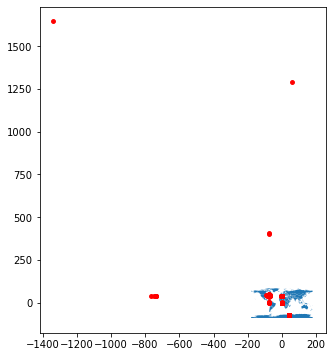

In [6]:
df = pd.DataFrame()
a = np.hstack((data[['pickup_longitude','pickup_latitude']],data[['dropoff_longitude','dropoff_latitude']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Let us first clear the obvious outliers: We need $-180 \leq lon \leq 180$ and $-90 \leq lat \leq 90$

In [7]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pickup_longitude']>180) | (data['pickup_longitude']<-180) | (data['pickup_latitude']>90) | (data['pickup_latitude']<-90))]
data = data[~((data['dropoff_longitude']>180) | (data['dropoff_longitude']<-180) | (data['dropoff_latitude']>90) | (data['dropoff_latitude']<-90))]

array([[<AxesSubplot:title={'center':'pickup_latitude'}>,
        <AxesSubplot:title={'center':'dropoff_latitude'}>],
       [<AxesSubplot:title={'center':'pickup_longitude'}>,
        <AxesSubplot:title={'center':'dropoff_longitude'}>]], dtype=object)

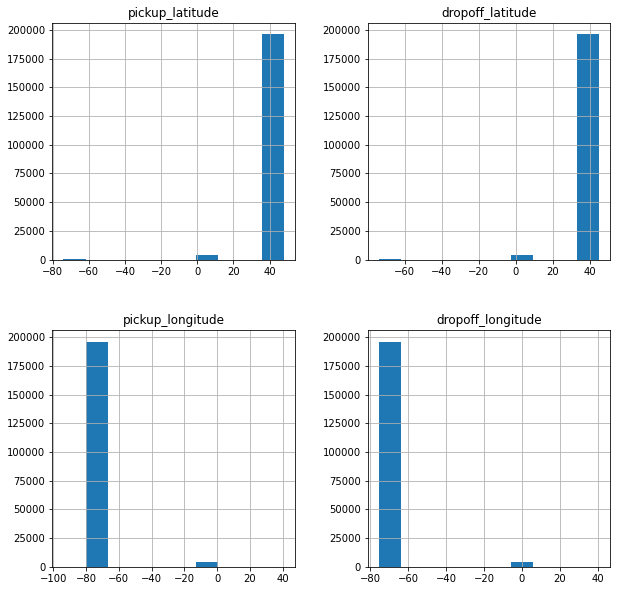

In [11]:
data.hist(["pickup_latitude","dropoff_latitude","pickup_longitude","dropoff_longitude"],figsize=(10,10))

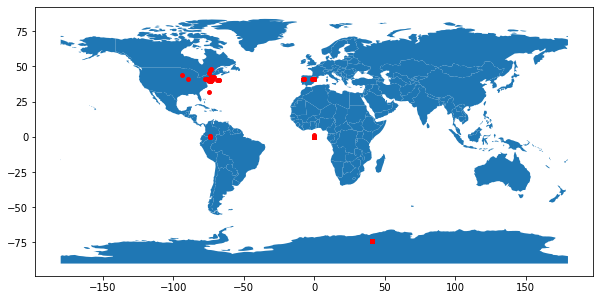

In [12]:
df = pd.DataFrame()
a = np.hstack((data[['pickup_longitude','pickup_latitude']],data[['dropoff_longitude','dropoff_latitude']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Let us only keep the rides from around NYC

In [4]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pickup_longitude']>-72) | (data['pickup_longitude']<-76) | (data['pickup_latitude']>42) | (data['pickup_latitude']<39))]
data = data[~((data['dropoff_longitude']>-72) | (data['dropoff_longitude']<-76) | (data['dropoff_latitude']>42) | (data['dropoff_latitude']<39))]

In [24]:
df = pd.DataFrame()
a = np.vstack((data[['pickup_longitude','pickup_latitude']],data[['dropoff_longitude','dropoff_latitude']]))
df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = GeoDataFrame(df, geometry=geometry)   
#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

(39.0, 42.0)

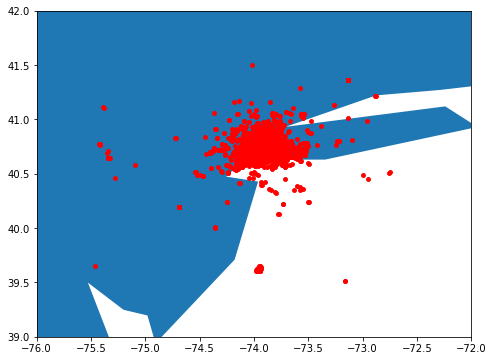

In [27]:
ax = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
ax.set_xlim(-76, -72)
ax.set_ylim(39,42)

In [12]:
# Drop the key column
data = data.drop(columns=["key"])
# Convert the pickup time column to datatime format
data.pickup_datetime = pd.to_datetime(data.pickup_datetime)
data.pickup_datetime = data.pickup_datetime.dt.tz_convert('America/New_York')

Add additional columns related to the pick up time such as the year, quarter, month, day of the month, day of the week, hour of the day, isweekday

In [13]:
data [["year","quarter","month","day","dayofweek","hour"]] = [[time.year,time.quarter, time.month,time.day,time.dayofweek,time.hour] for time in data.pickup_datetime]
data["isweekend"] = (data.dayofweek > 4)*1

In [14]:
data

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,quarter,month,day,dayofweek,hour,isweekend
24238194,7.5,2015-05-07 15:52:06-04:00,-73.999817,40.738354,-73.999512,40.723217,1,2015,2,5,7,3,15,0
27835199,7.7,2009-07-17 16:04:56-04:00,-73.994355,40.728225,-73.994710,40.750325,1,2009,3,7,17,4,16,0
44984355,12.9,2009-08-24 17:45:00-04:00,-74.005043,40.740770,-73.962565,40.772647,1,2009,3,8,24,0,17,0
25894730,5.3,2009-06-26 04:22:21-04:00,-73.976124,40.790844,-73.965316,40.803349,3,2009,2,6,26,4,4,0
17610152,16.0,2014-08-28 13:47:00-04:00,-73.925023,40.744085,-73.973082,40.761247,5,2014,3,8,28,3,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42598914,3.0,2012-10-28 06:49:00-04:00,-73.987042,40.739367,-73.986525,40.740297,1,2012,4,10,28,6,6,1
16382965,7.5,2014-03-13 21:09:00-04:00,-73.984722,40.736837,-74.006672,40.739620,1,2014,1,3,13,3,21,0
27804658,30.9,2009-06-28 20:42:00-04:00,-73.986017,40.756487,-73.858957,40.692588,2,2009,2,6,28,6,20,1
20259894,14.5,2015-05-20 10:56:25-04:00,-73.997124,40.725452,-73.983215,40.695415,1,2015,2,5,20,2,10,0


In [6]:
graph_area = ["New York, USA","New Jersey, USA"]
G = ox.graph_from_place(graph_area, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ox.save_graphml(G, "NewYork.graphml")

# G = ox.load_graphml("Manhattan.graphml")

# origin_coordinates = (40.70195053163349, -74.01123198479581)
# destination_coordinates = (40.87148739347057, -73.91517498611597)
# origin_node = ox.distance.nearest_nodes(G, origin_coordinates[1], origin_coordinates[0])
# destination_node = ox.distance.nearest_nodes(G, destination_coordinates[1], destination_coordinates[0])

# distance_in_meters = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
# print(distance_in_meters)

/Users/nikhil/opt/anaconda3/envs/ORIE5751/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/Users/nikhil/opt/anaconda3/envs/ORIE5751/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


KeyboardInterrupt: 

<AxesSubplot:xlabel='pickup_longitude', ylabel='pickup_latitude'>

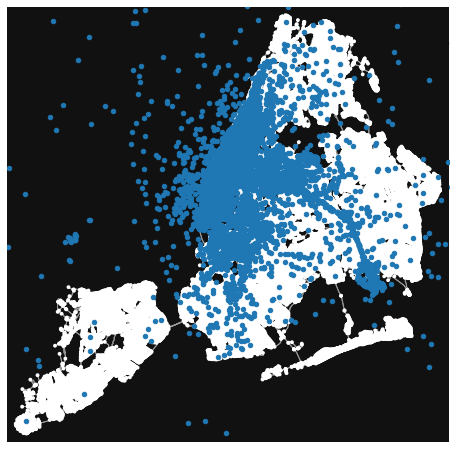

In [28]:
fig, ax = ox.plot_graph(G, show=False, close=False)
data.plot(x='pickup_longitude',y='pickup_latitude',kind='scatter',ax=ax)

In [17]:
df

,lon,lat,geometry
0,-73.999817,40.738354,POINT (-73.99982 40.73835)
1,-73.994355,40.728225,POINT (-73.99435 40.72823)
2,-74.005043,40.740770,POINT (-74.00504 40.74077)
3,-73.976124,40.790844,POINT (-73.97612 40.79084)
4,-73.925023,40.744085,POINT (-73.92502 40.74408)
...,...,...,...
195842,-73.987042,40.739367,POINT (-73.98704 40.73937)
195843,-73.984722,40.736837,POINT (-73.98472 40.73684)
195844,-73.986017,40.756487,POINT (-73.98602 40.75649)
195845,-73.997124,40.725452,POINT (-73.99712 40.72545)


In [18]:
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...,...
42598914,2012-10-28 10:49:00.00000053,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
16382965,2014-03-14 01:09:00.0000008,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
27804658,2009-06-29 00:42:00.00000078,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
20259894,2015-05-20 14:56:25.0000004,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [7]:
X = data[['pickup_longitude','pickup_latitude']] # np.hstack((data[['pickup_longitude','pickup_latitude']],data[['dropoff_longitude','dropoff_latitude']]))

In [9]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


In [10]:
neighbors = X.shape[1]*2
ns = X.shape[0]
# X_embedded is your data
nbrs = NearestNeighbors(n_neighbors=neighbors).fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]



(199975.0, 200000.0)

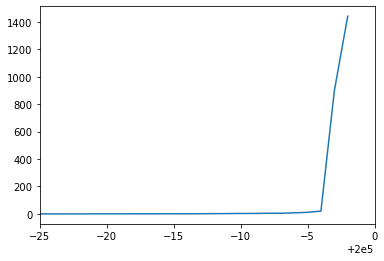

In [11]:
plt.plot(distances)
plt.xlim(xmin = 199975,xmax=200000)

In [12]:
eps = 1
clustering = DBSCAN(eps=eps, min_samples=neighbors).fit(X)

In [1]:
clustering.labels_

NameError: name 'clustering' is not defined